In [161]:
# Step 1: Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

# NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\work\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\work\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\work\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [162]:
# Step 2: Load dataset
resume_dataset = pd.read_csv("UpdatedResumeDataSet.csv")
print(f"Dataset shape: {resume_dataset.shape}")
print(f"Number of categories: {resume_dataset['Category'].nunique()}")
resume_dataset.head()

Dataset shape: (962, 2)
Number of categories: 25


Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...

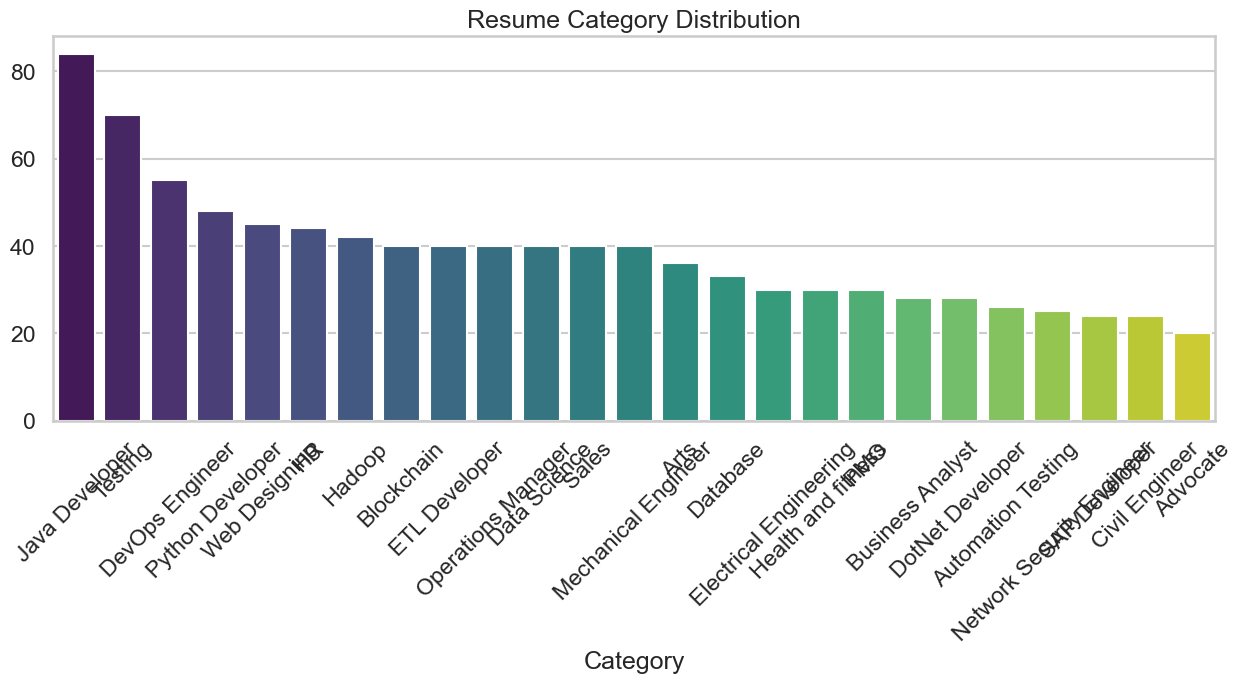

In [163]:
# Category distribution
plt.figure(figsize=(15,5))
category_counts = resume_dataset['Category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.title("Resume Category Distribution")
plt.show()


In [164]:
# Step 3: Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

resume_dataset['cleaned'] = resume_dataset['Resume'].apply(clean_text)
print("Text preprocessing completed.")


Text preprocessing completed.


In [165]:
# Step 4: TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=3000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1,2),
    stop_words='english'
)

X = resume_dataset['cleaned']
y = resume_dataset['Category']
X_tfidf = vectorizer.fit_transform(X)

print(f"Feature matrix shape: {X_tfidf.shape}")


Feature matrix shape: (962, 3000)


In [166]:
# Step 5: Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Training samples: 769, Test samples: 193


In [167]:
# Step 6: Encode labels & define models
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Label encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=0.5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42),
    'SVM': SVC(C=1.0, kernel='linear', probability=True, random_state=42),
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'Decision Tree': DecisionTreeClassifier(max_depth=15, random_state=42),
    'XGBoost': XGBClassifier(max_depth=6, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

In [168]:
# Step 7: Training and evaluation
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    cv_scores = cross_val_score(model, X_train, y_train_enc, cv=cv, scoring='accuracy')
    model.fit(X_train, y_train_enc)
    
    y_pred_enc = model.predict(X_test)
    y_pred = le.inverse_transform(y_pred_enc)
    
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'accuracy': accuracy_score(y_test, y_pred),
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"{name} - Test Accuracy: {results[name]['accuracy']:.4f}, CV: {cv_scores.mean():.4f}")


Training Logistic Regression...
Logistic Regression - Test Accuracy: 0.9845, CV: 0.9818
Training Random Forest...
Random Forest - Test Accuracy: 0.9948, CV: 0.9935
Training SVM...
SVM - Test Accuracy: 0.9948, CV: 0.9961
Training Naive Bayes...
Naive Bayes - Test Accuracy: 0.9896, CV: 0.9922
Training Decision Tree...
Decision Tree - Test Accuracy: 0.7254, CV: 0.7191
Training XGBoost...
XGBoost - Test Accuracy: 1.0000, CV: 0.9961


                 Model  Test Accuracy  CV Mean Accuracy    CV Std
2                  SVM       0.994819          0.996095  0.003188
5              XGBoost       1.000000          0.996095  0.003188
1        Random Forest       0.994819          0.993490  0.004134
3          Naive Bayes       0.989637          0.992191  0.004878
0  Logistic Regression       0.984456          0.981784  0.012613
4        Decision Tree       0.725389          0.719065  0.026071


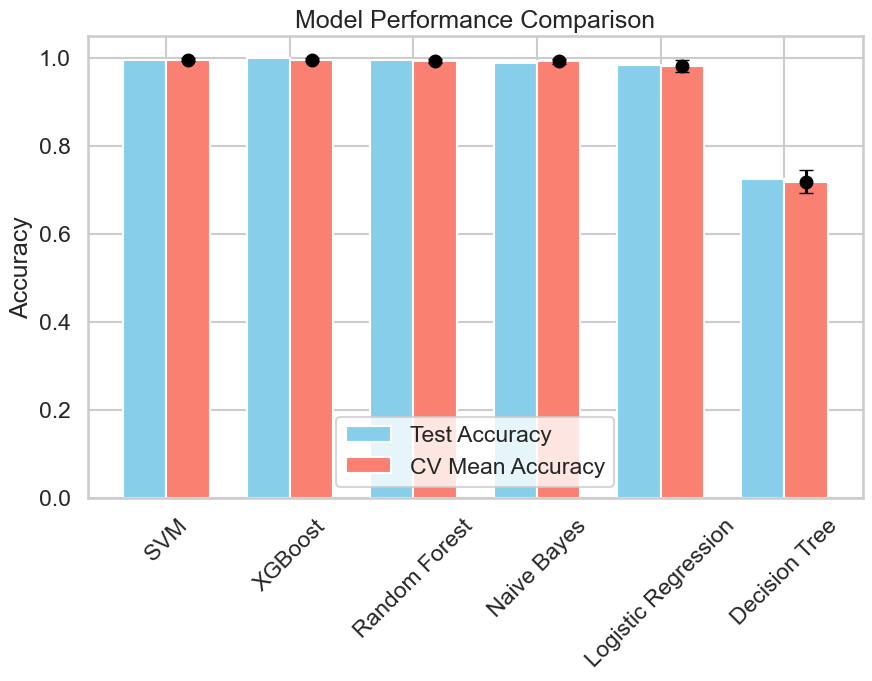

In [169]:
# Step 8: Compare models
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'CV Mean Accuracy': [results[name]['cv_mean'] for name in results.keys()],
    'CV Std': [results[name]['cv_std'] for name in results.keys()]
}).sort_values('CV Mean Accuracy', ascending=False)

print(comparison_df)

plt.figure(figsize=(10,6))
x_pos = np.arange(len(comparison_df))
width = 0.35

plt.bar(x_pos - width/2, comparison_df['Test Accuracy'], width, label='Test Accuracy', color='skyblue')
plt.bar(x_pos + width/2, comparison_df['CV Mean Accuracy'], width, label='CV Mean Accuracy', color='salmon')
plt.errorbar(x_pos + width/2, comparison_df['CV Mean Accuracy'], yerr=comparison_df['CV Std'], fmt='o', color='black', capsize=5)
plt.xticks(x_pos, comparison_df['Model'], rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()


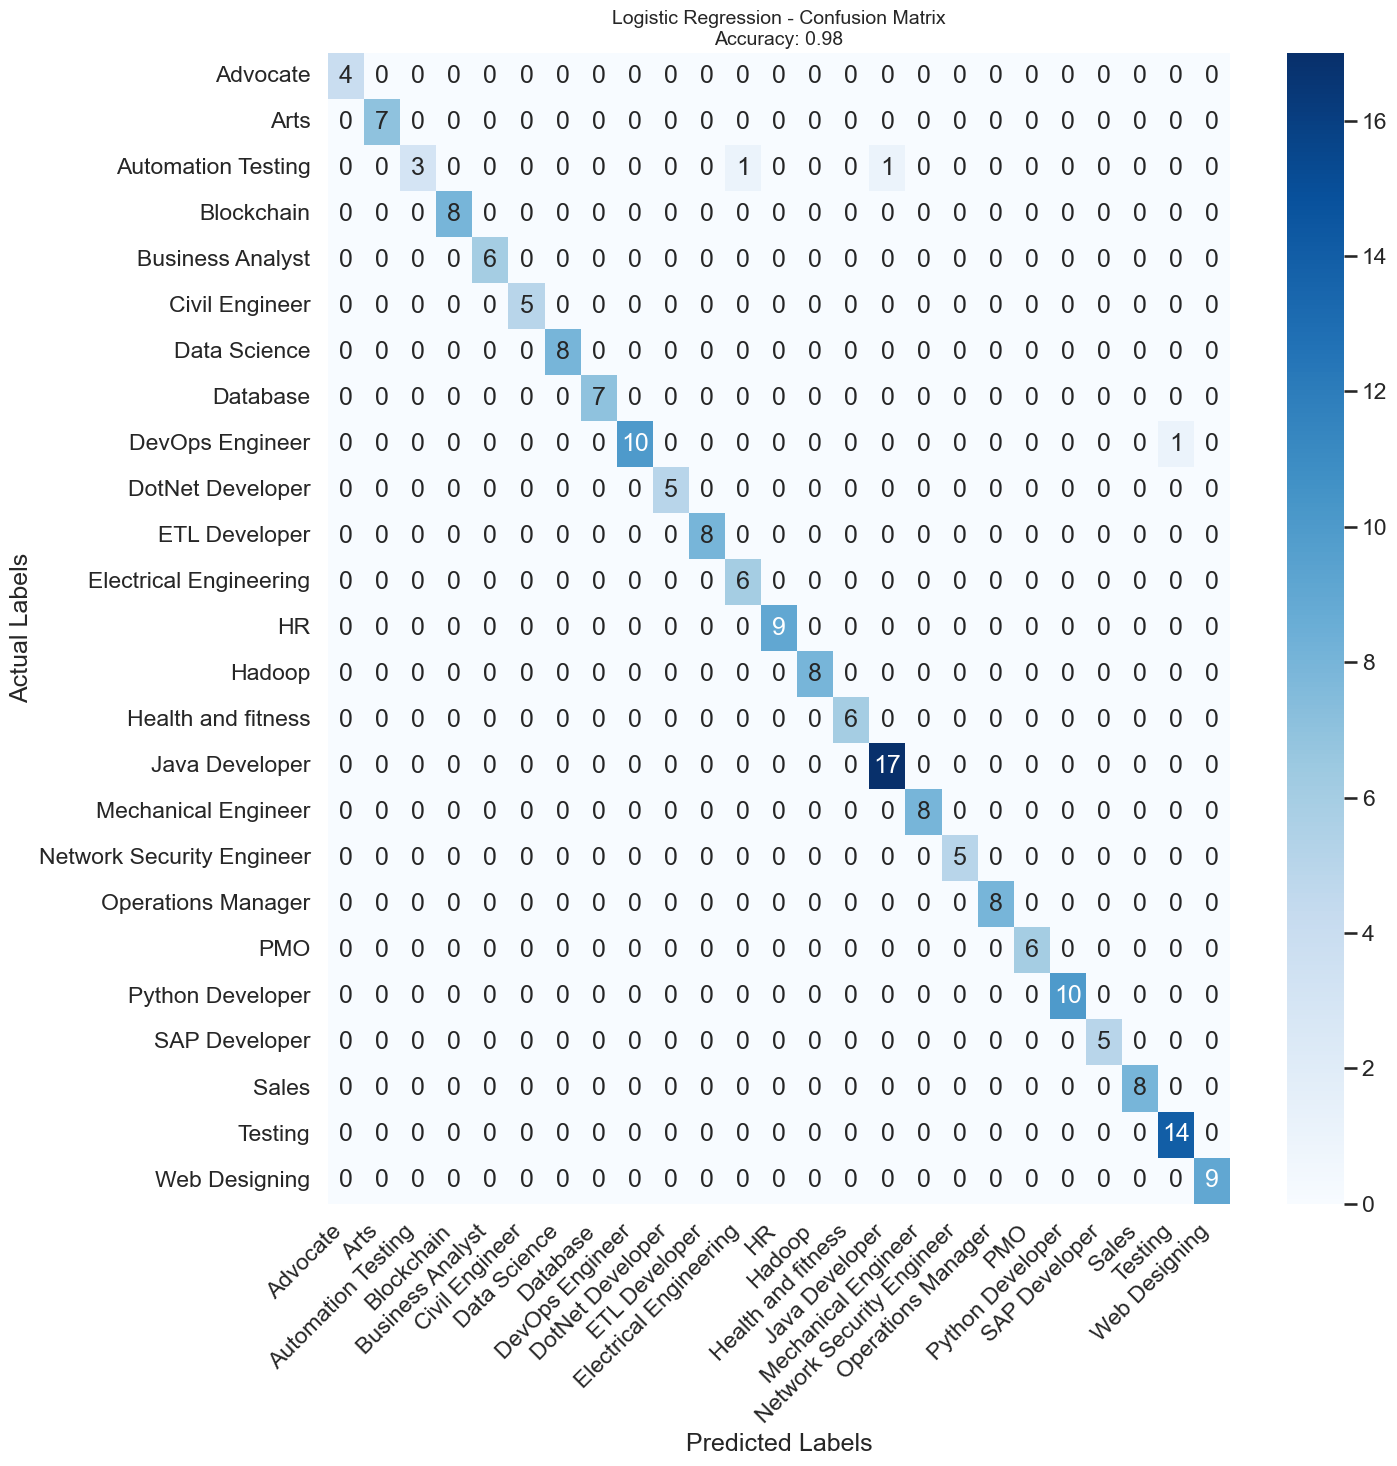

✅ Displayed Confusion Matrix for Logistic Regression


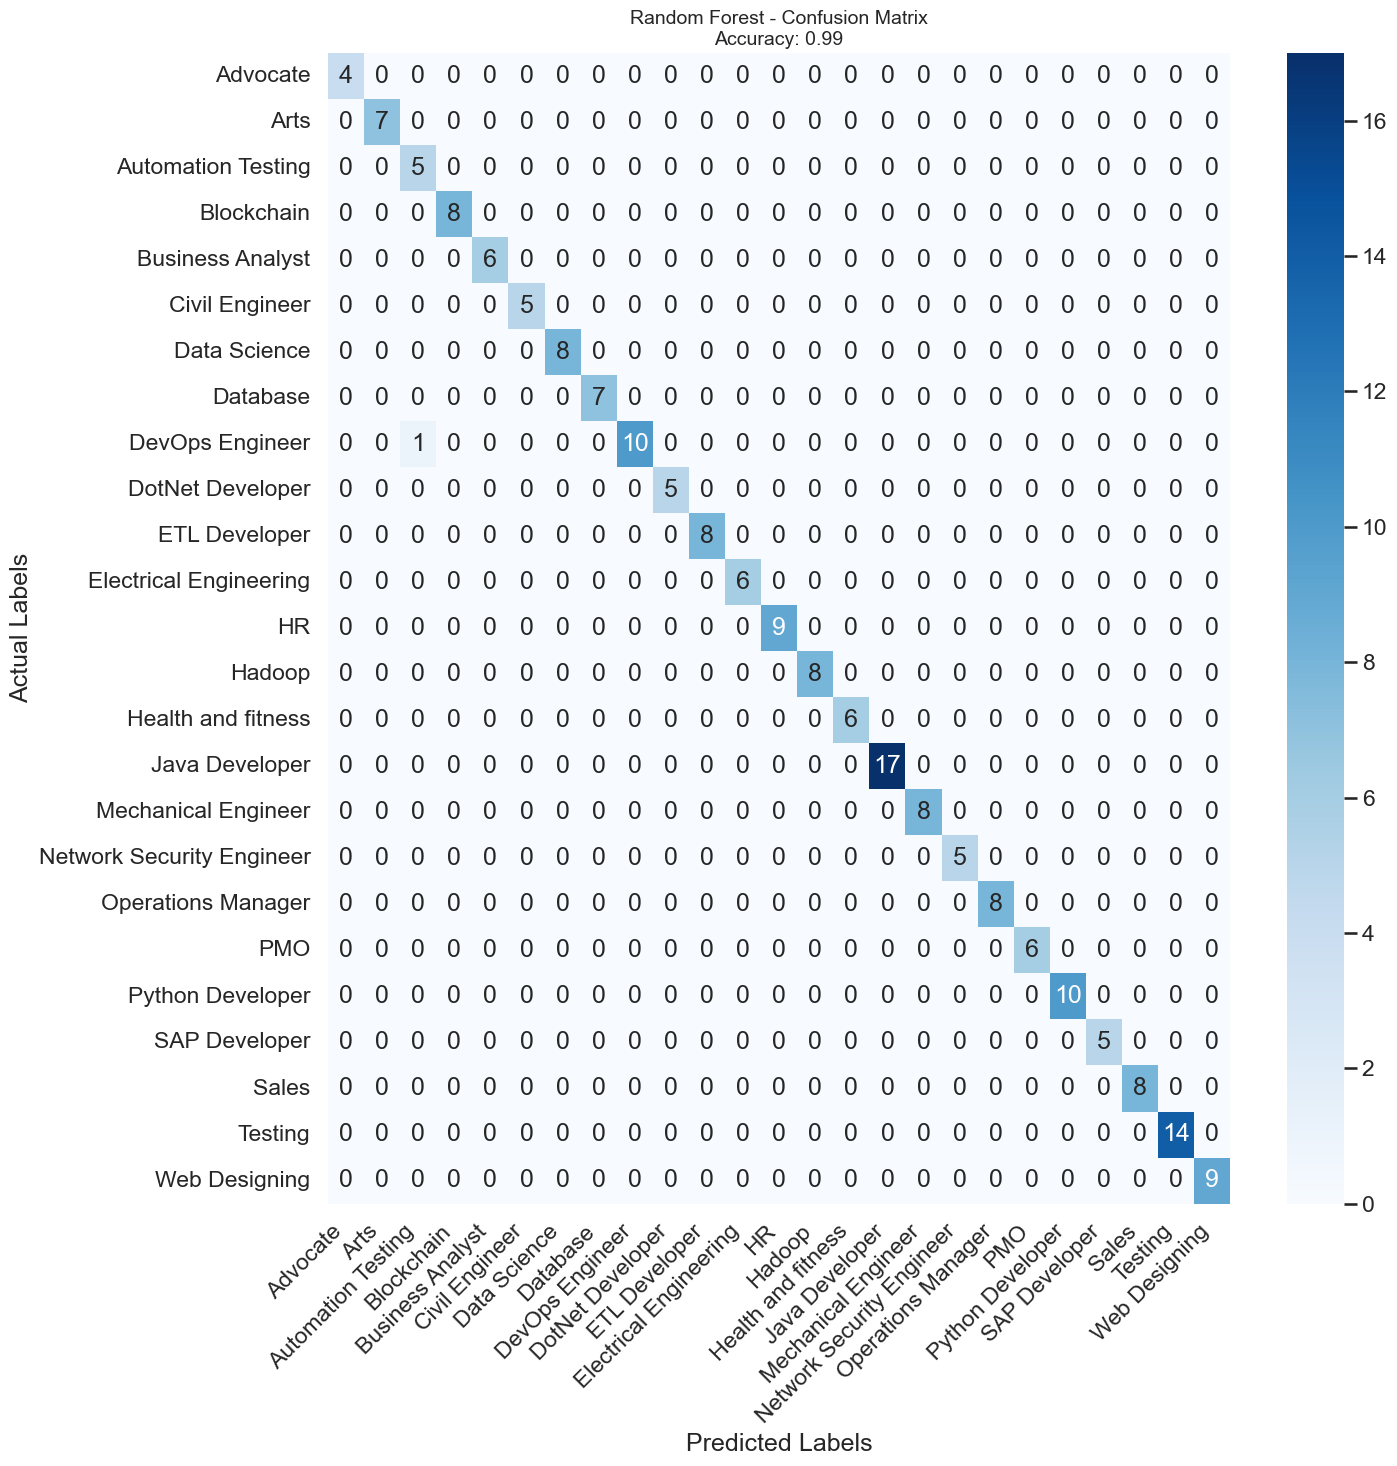

✅ Displayed Confusion Matrix for Random Forest


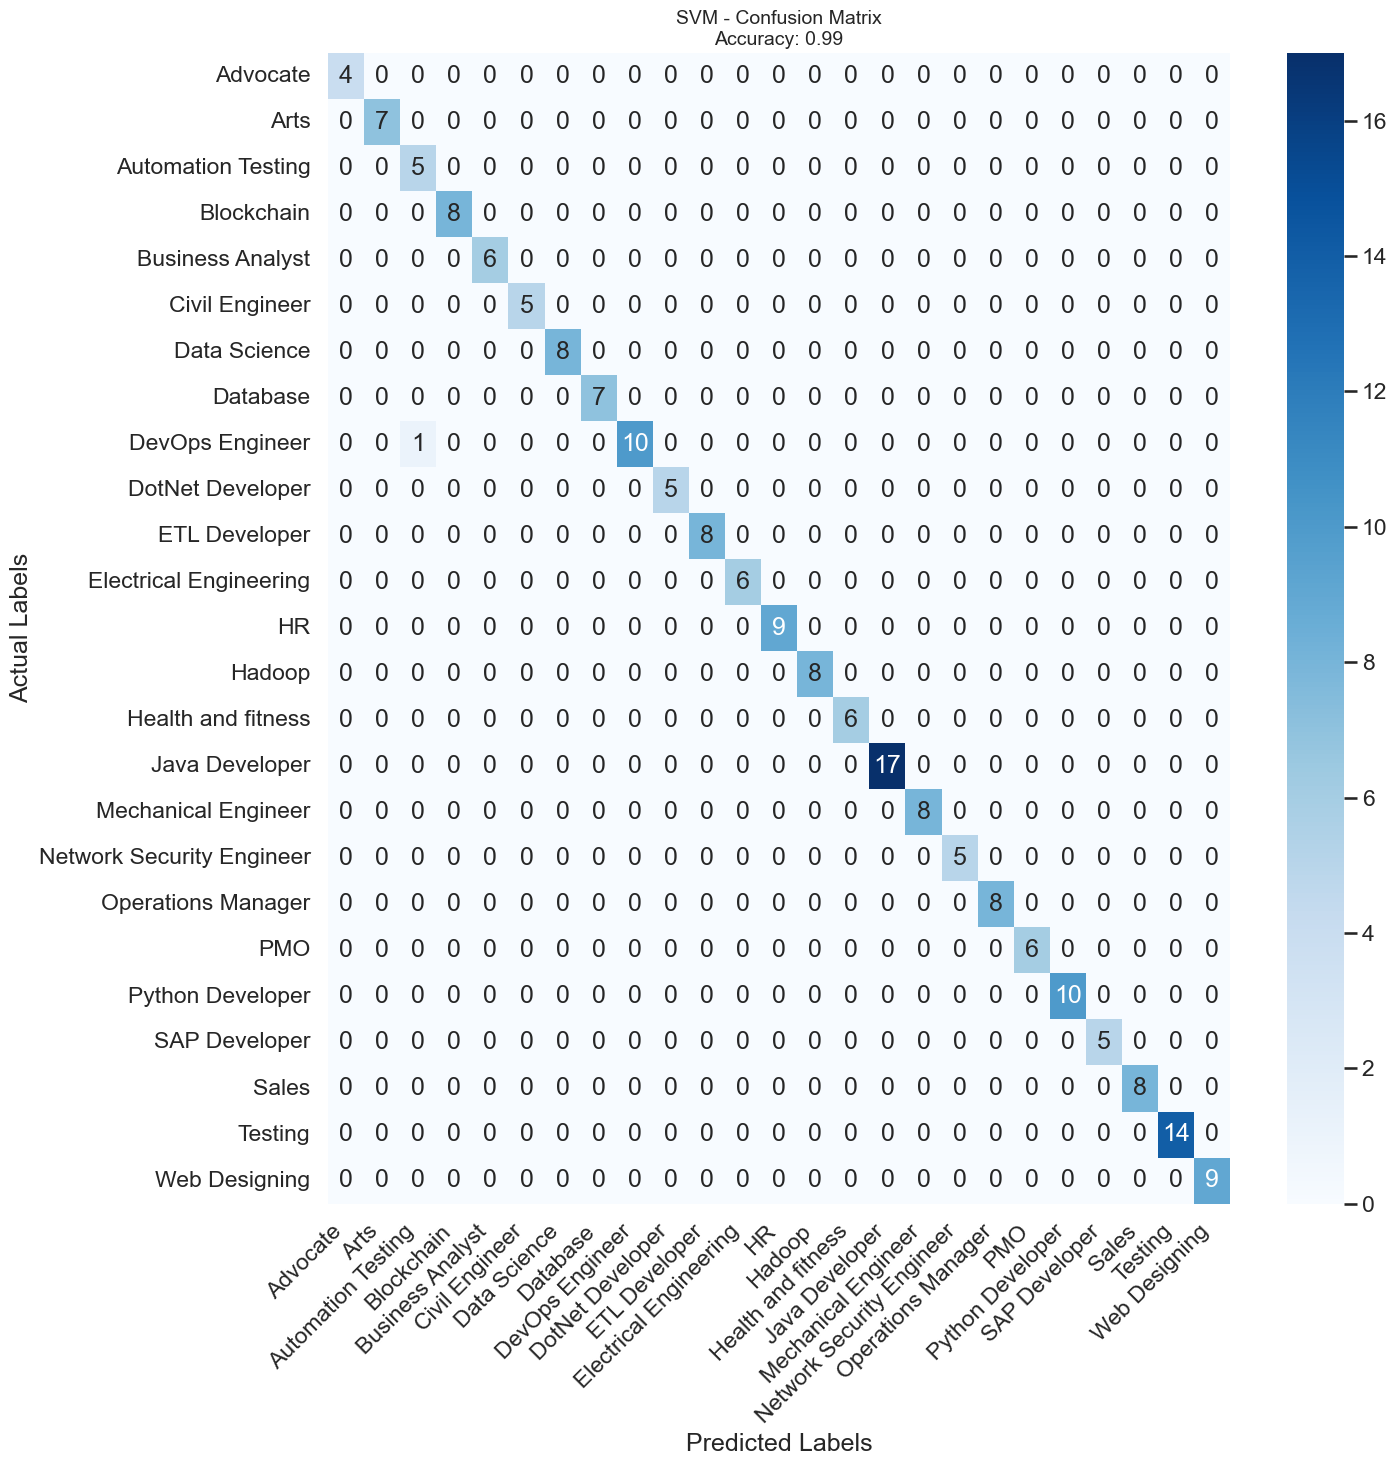

✅ Displayed Confusion Matrix for SVM


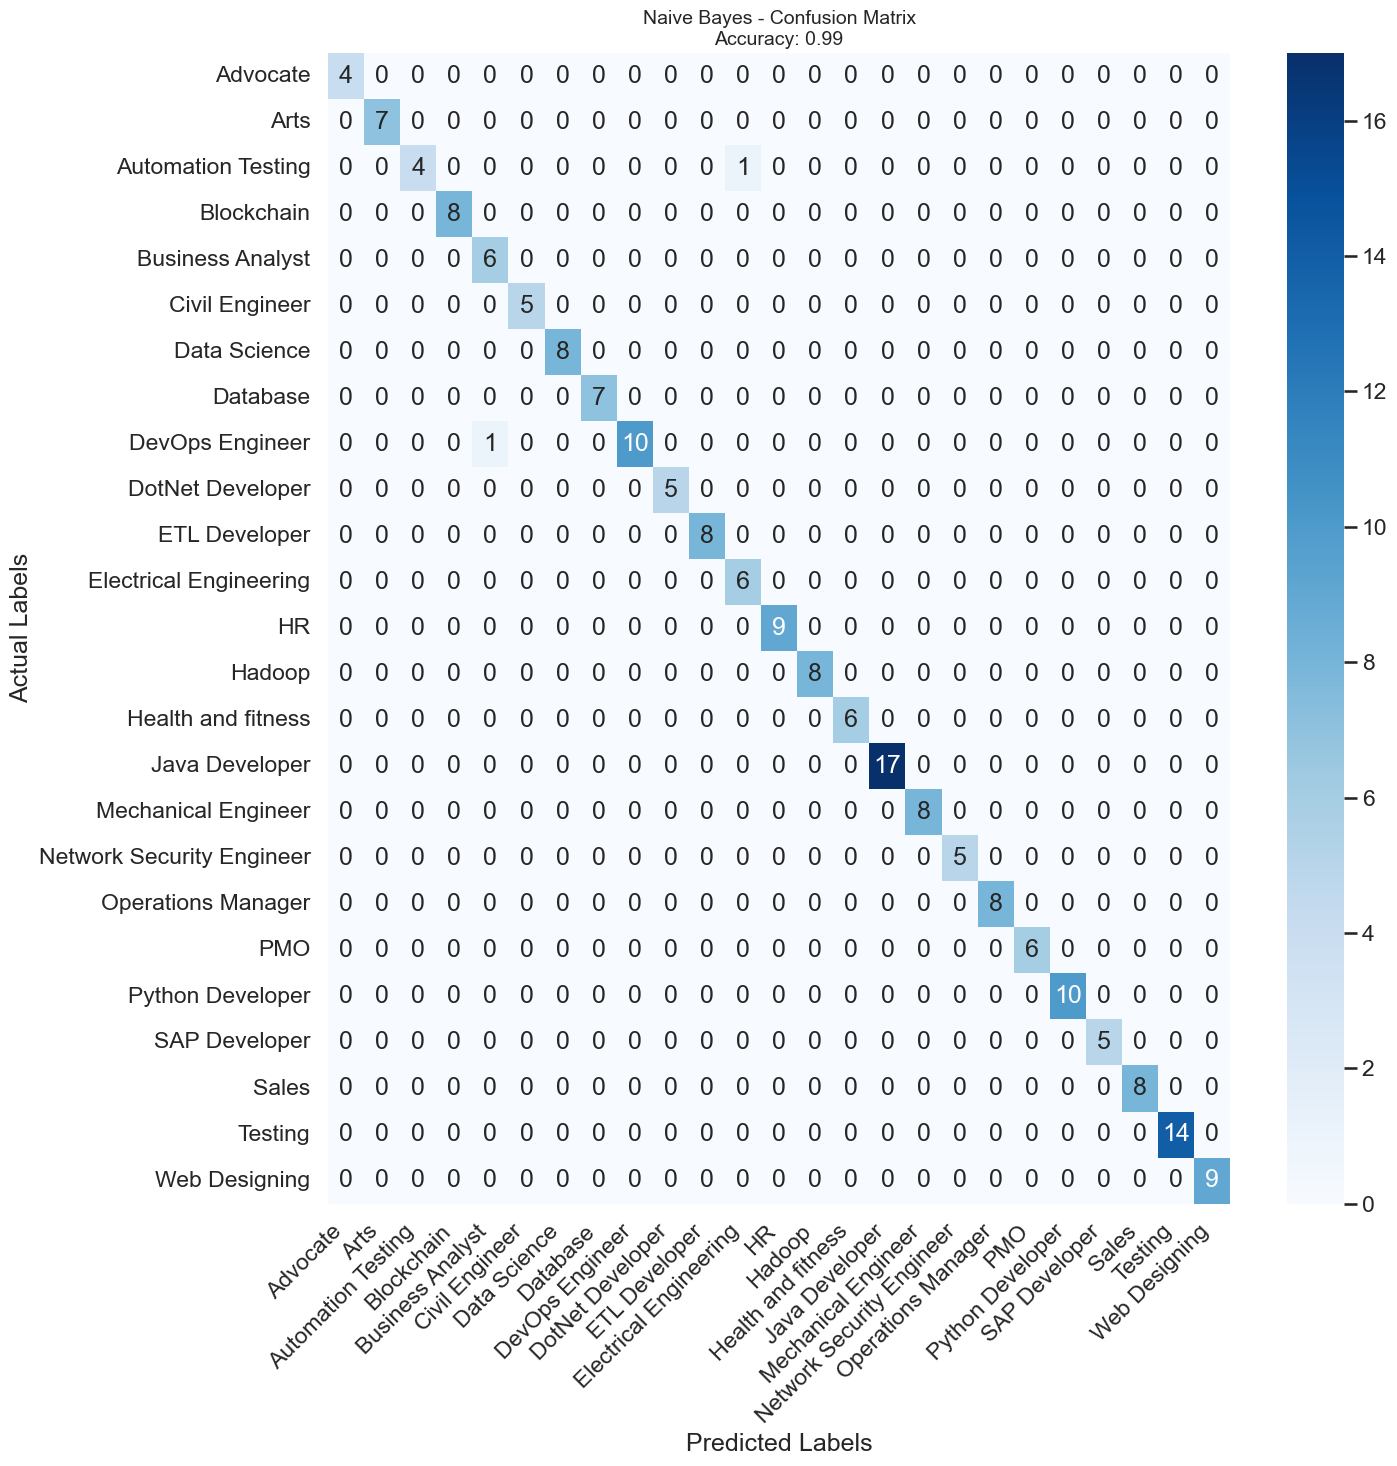

✅ Displayed Confusion Matrix for Naive Bayes


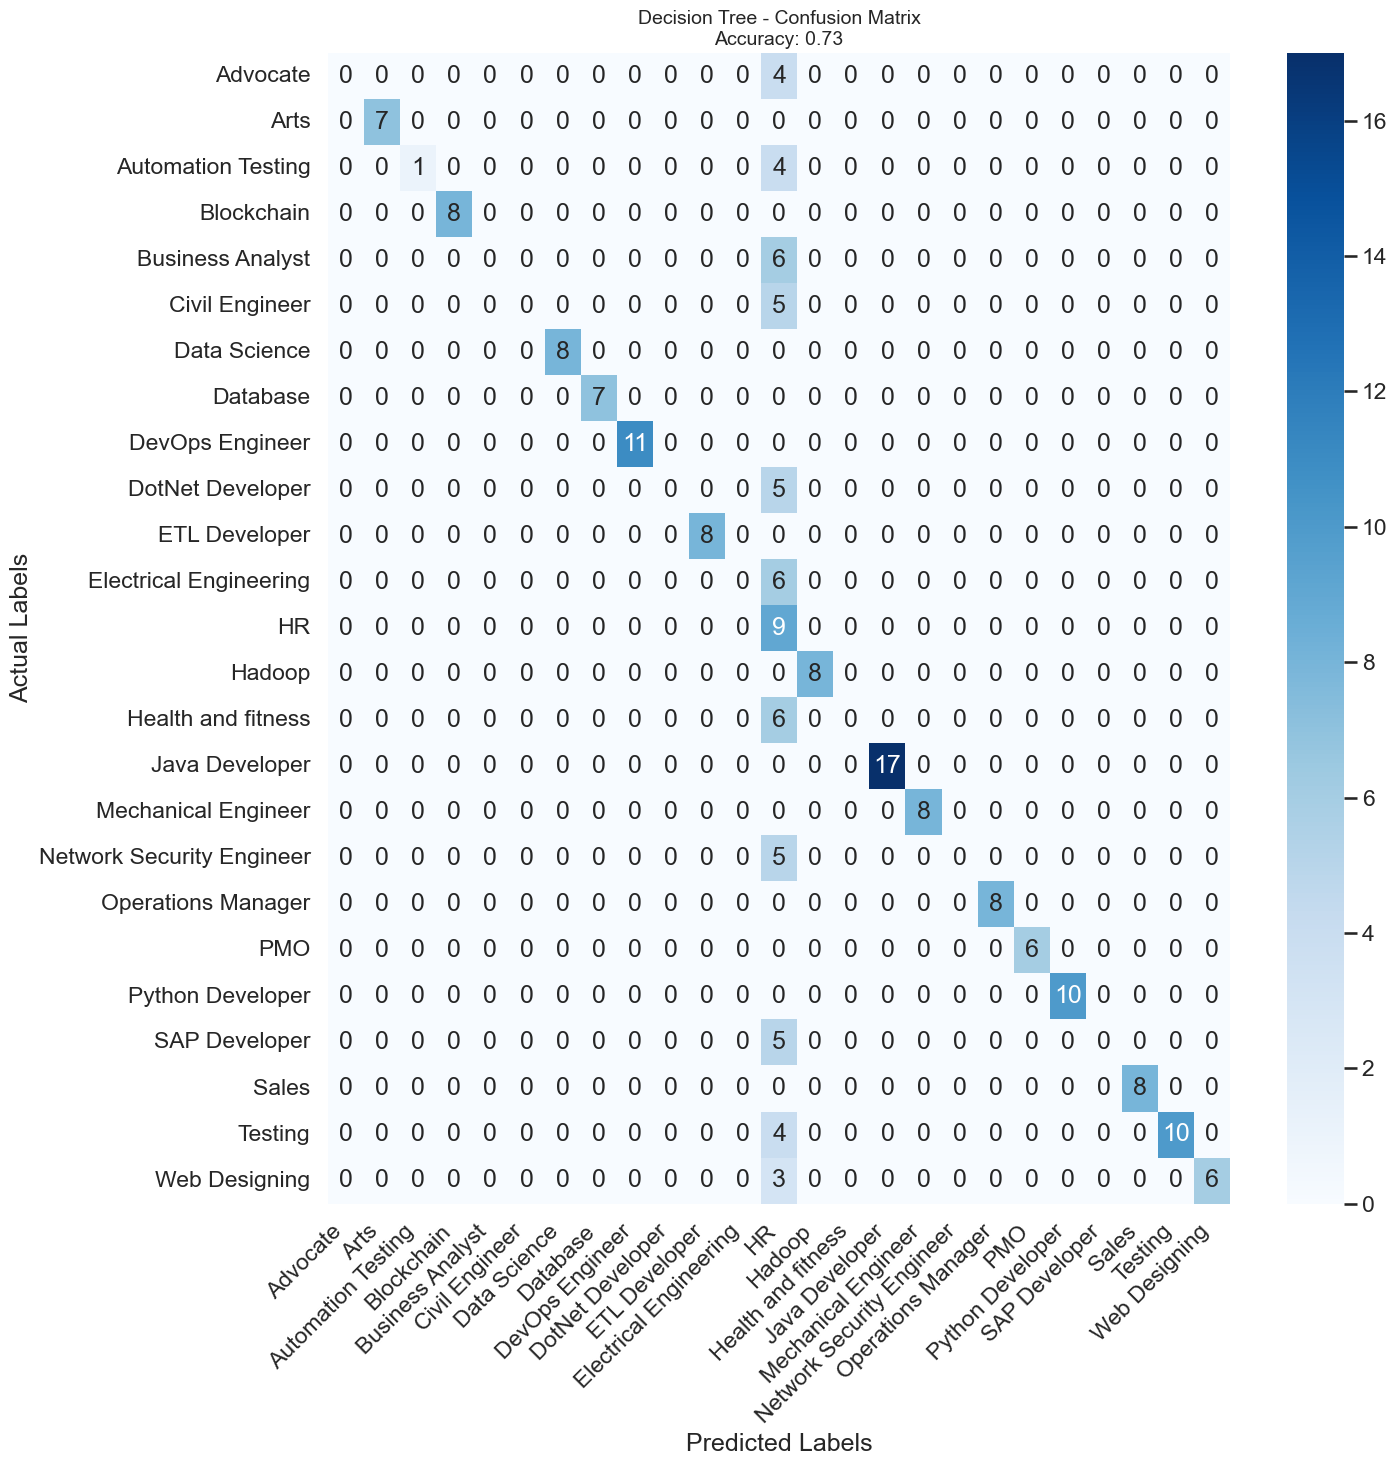

✅ Displayed Confusion Matrix for Decision Tree


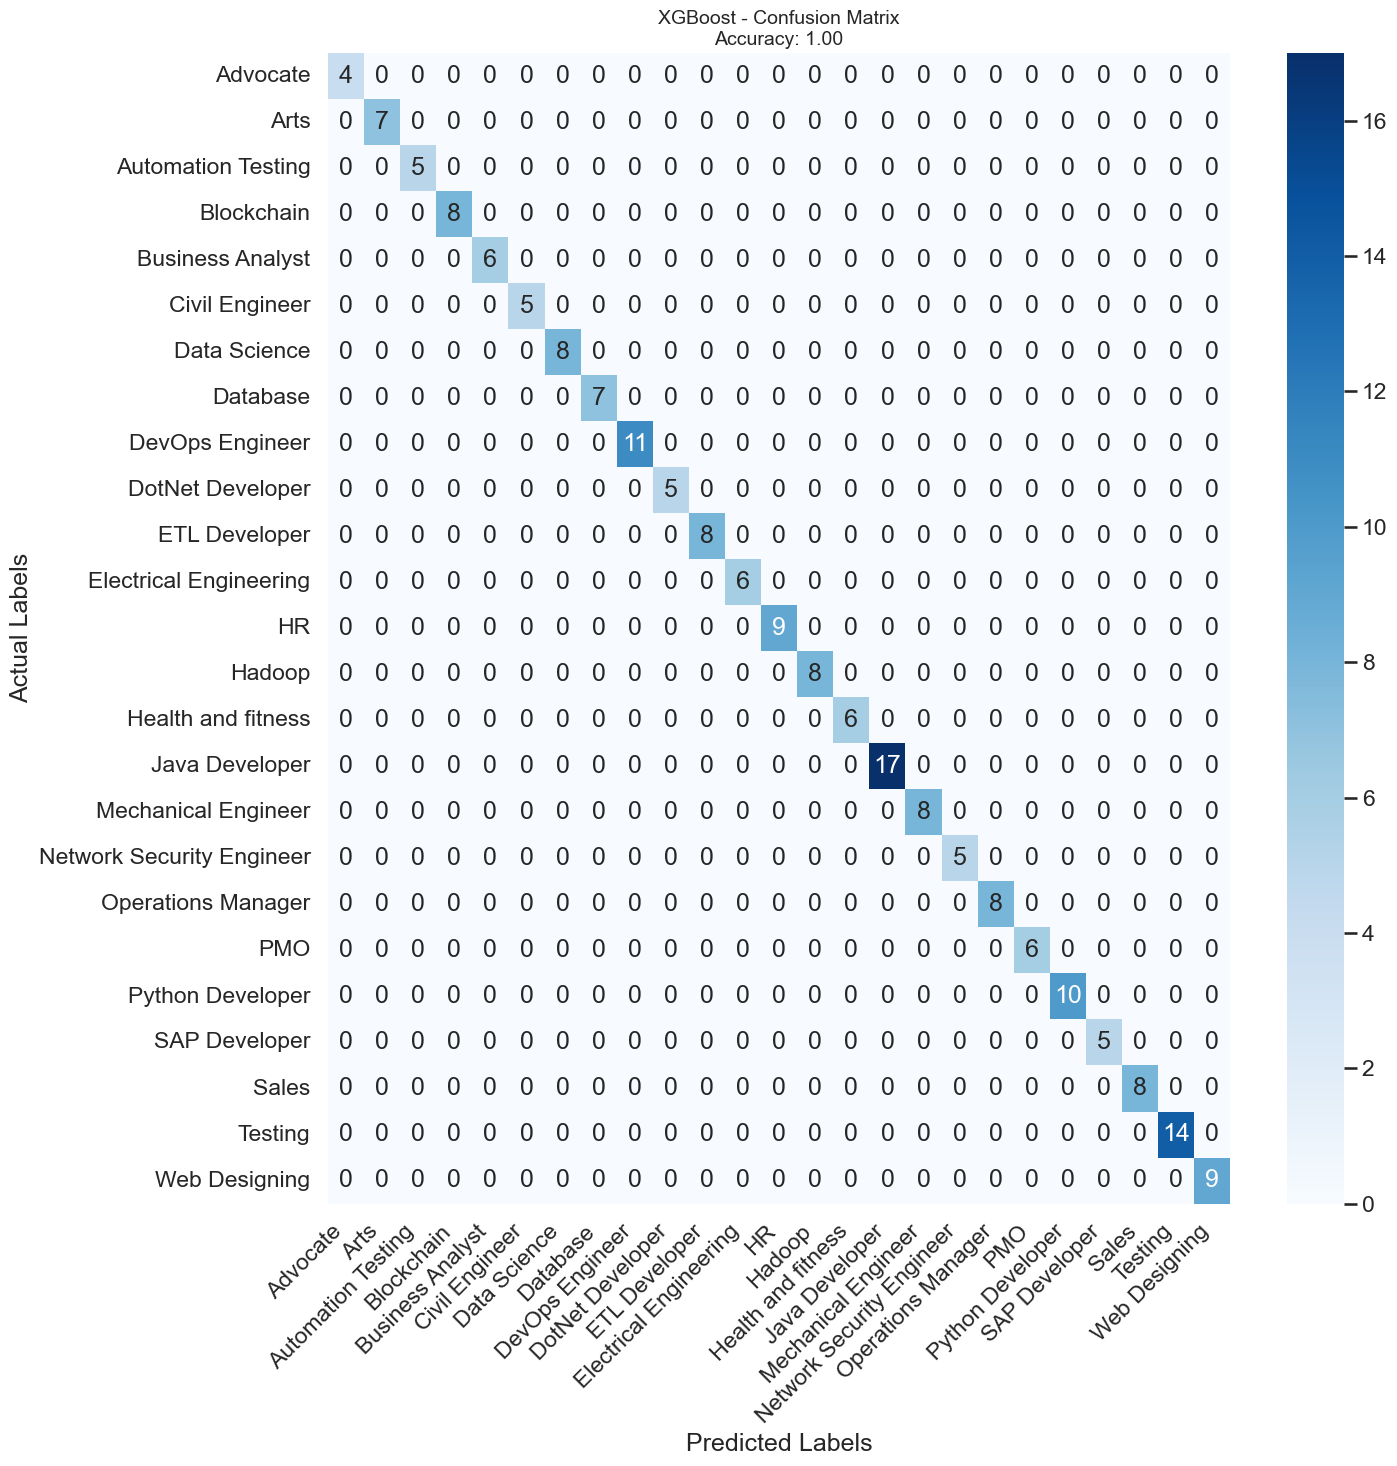

✅ Displayed Confusion Matrix for XGBoost


In [191]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix_all(models_dict, X_test, y_test, le):
    """Show confusion matrix one by one for all models"""
    for model_name, model_data in models_dict.items():
        model = model_data['model']
        y_pred_enc = model.predict(X_test)
        y_pred = le.inverse_transform(y_pred_enc)
        
        cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
        
        plt.figure(figsize=(15, 15))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=le.classes_,
                    yticklabels=le.classes_)
        
        plt.title(f"{model_name} - Confusion Matrix\nAccuracy: {model_data['accuracy']:.2f}", fontsize=14)
        plt.xlabel("Predicted Labels")
        plt.ylabel("Actual Labels")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Displayed Confusion Matrix for {model_name}\n{'='*60}")

plot_confusion_matrix_all(results, X_test, y_test, le)


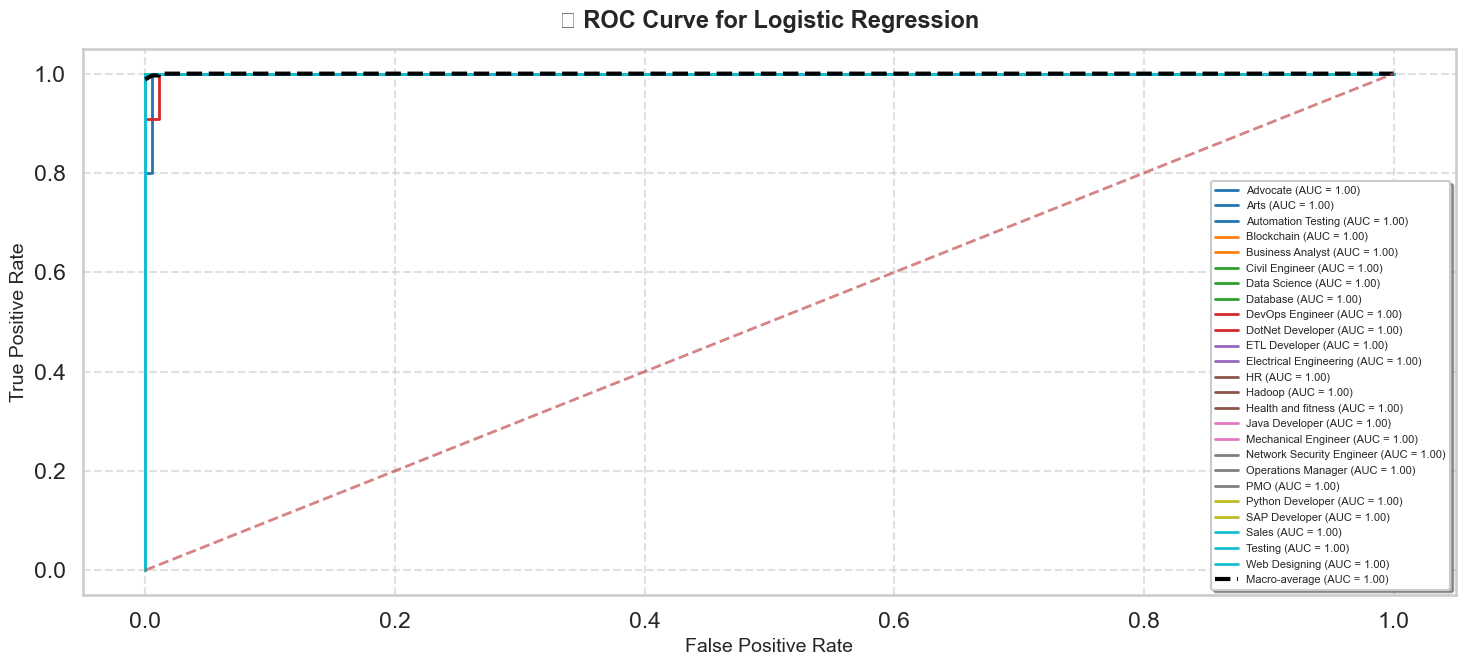

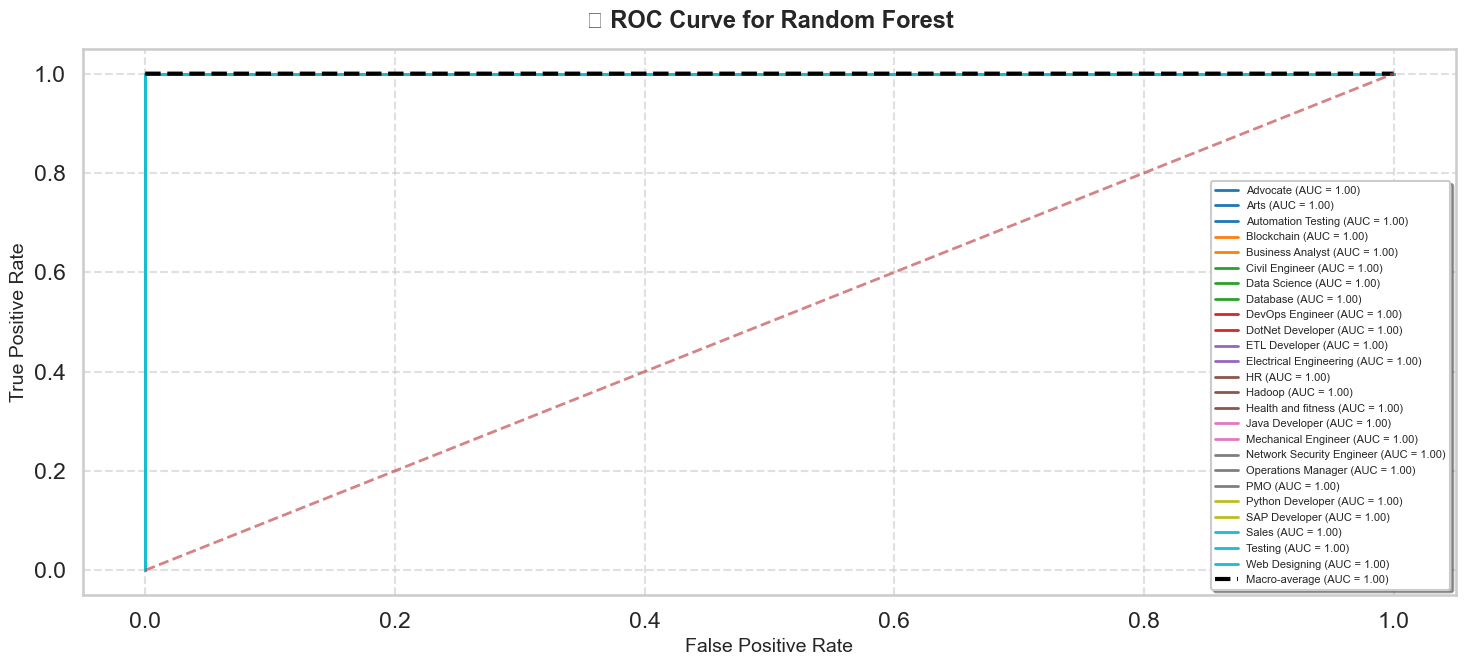

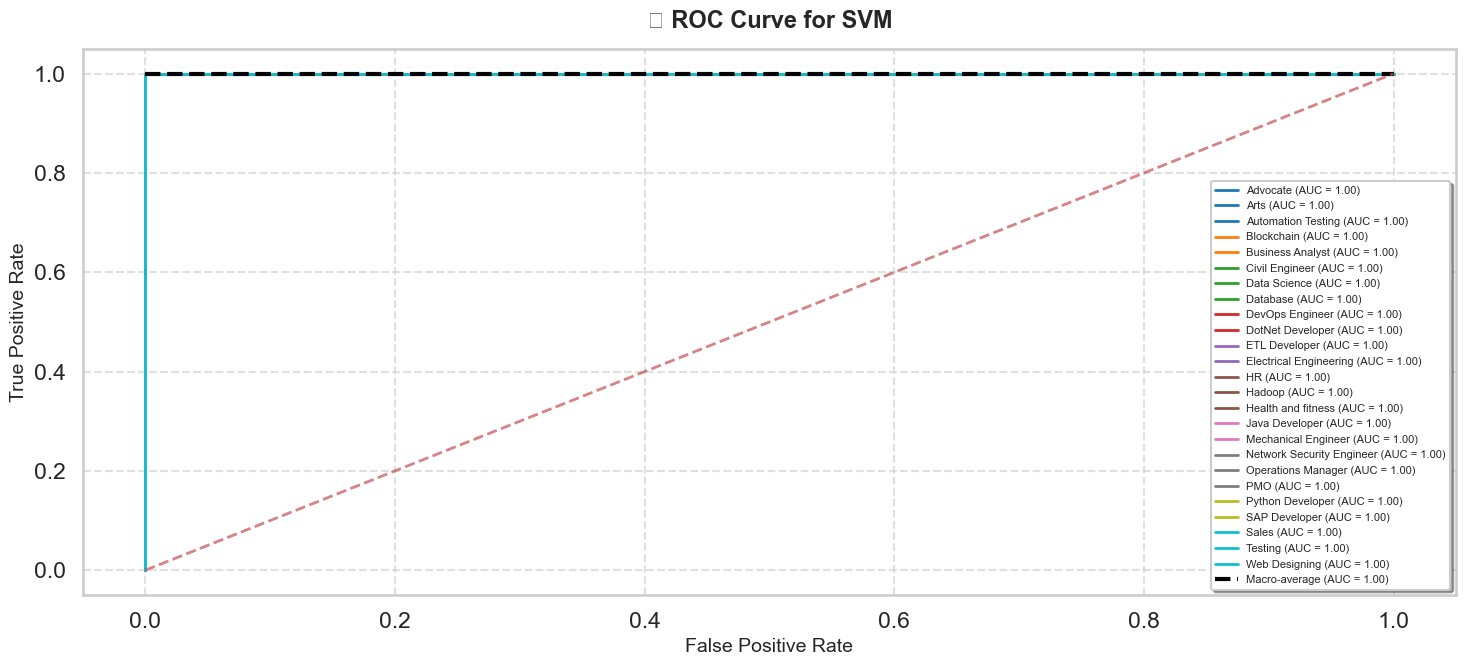

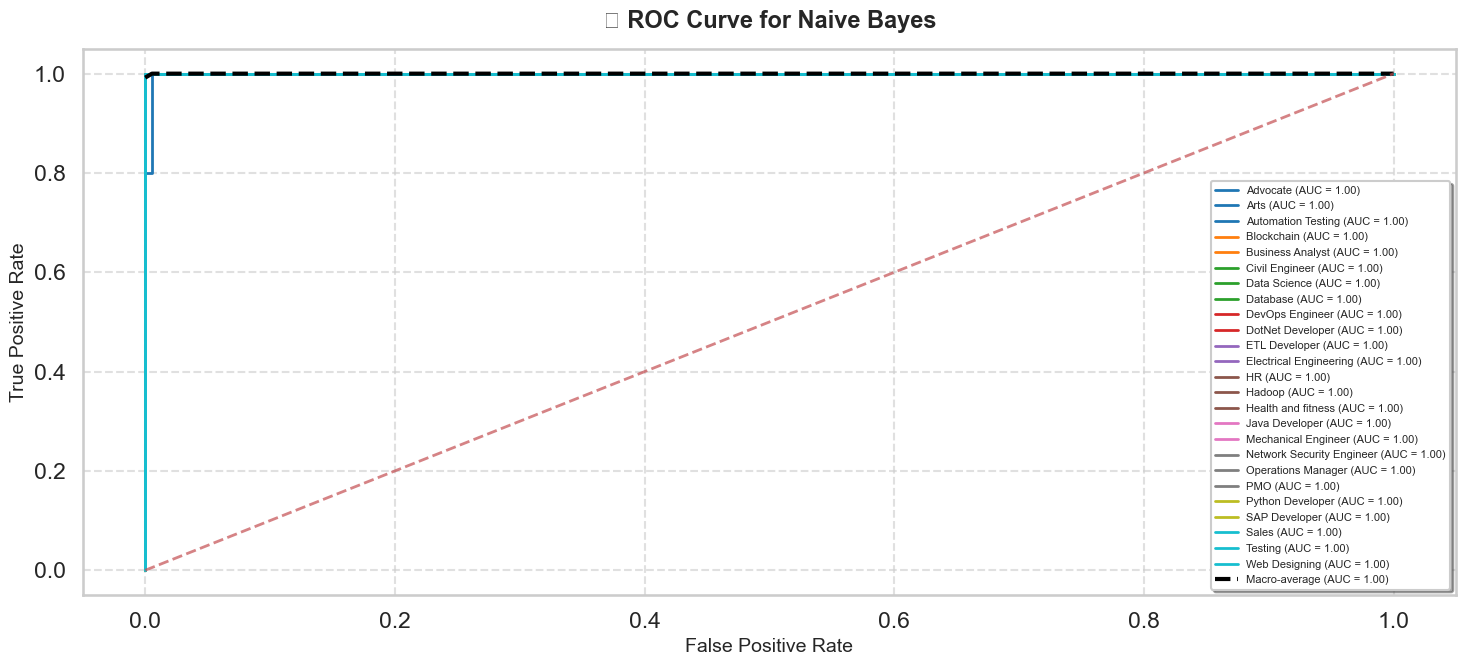

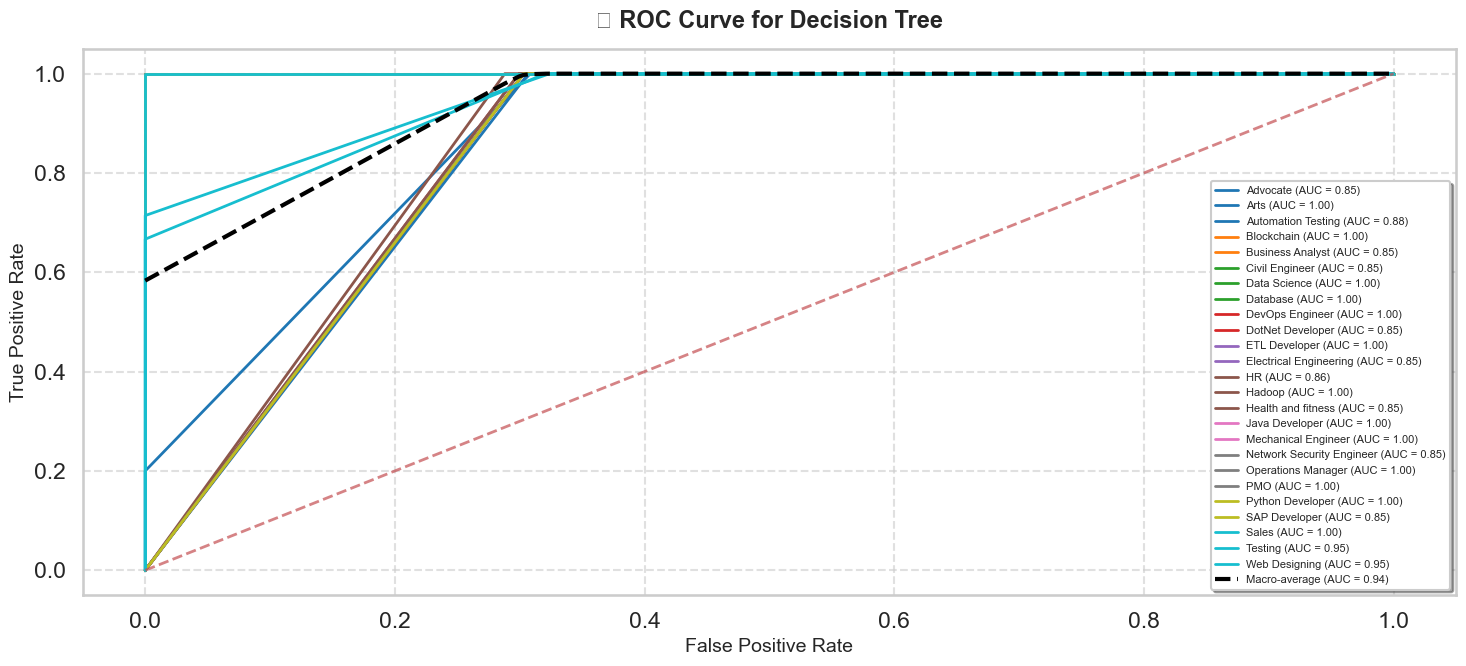

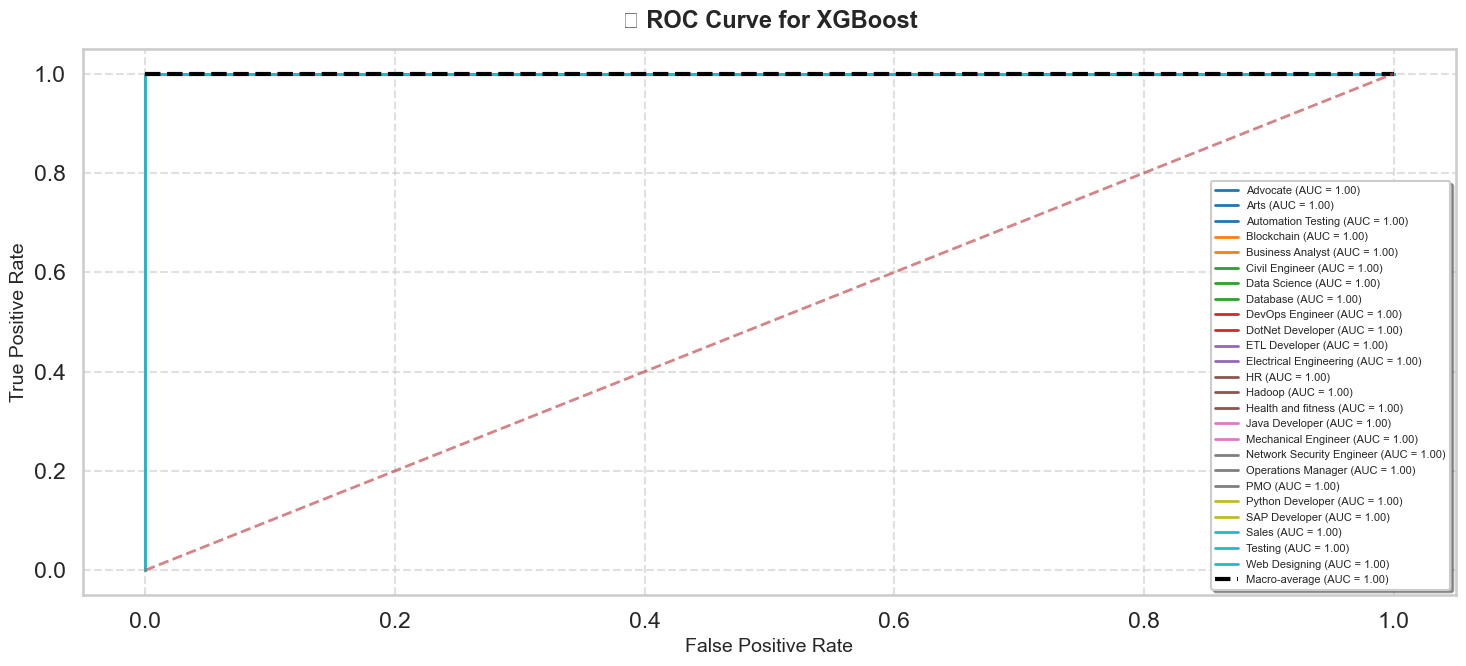

In [171]:
# Step 10: ROC Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

sns.set_theme(style="whitegrid", context="talk")

def plot_best_roc(models_dict, X_test, y_test, le):
    """
    Create detailed, presentation-level ROC plots for each model.
    Includes class-wise and macro-average curves.
    """
    y_test_bin = label_binarize(y_test, classes=le.classes_)
    n_classes = y_test_bin.shape[1]

    for model_name, model_data in models_dict.items():
        model = model_data["model"]
        if not hasattr(model, "predict_proba"):
            print(f"Skipping {model_name} (no probability output)")
            continue

        y_score = model.predict_proba(X_test)

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        roc_auc["macro"] = auc(all_fpr, mean_tpr)
        plt.figure(figsize=(15, 7))
        colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")
        plt.plot(all_fpr, mean_tpr, color='black', linestyle='--', lw=3,
                 label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")
        plt.plot([0, 1], [0, 1], 'r--', lw=2, alpha=0.7)
        plt.title(f"🏆 ROC Curve for {model_name}", fontsize=17, fontweight="bold", pad=15)
        plt.xlabel("False Positive Rate", fontsize=14)
        plt.ylabel("True Positive Rate", fontsize=14)
        plt.legend(fontsize=8, loc="lower right", frameon=True, fancybox=True, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        plt.show()
plot_best_roc(results, X_test, y_test, le)


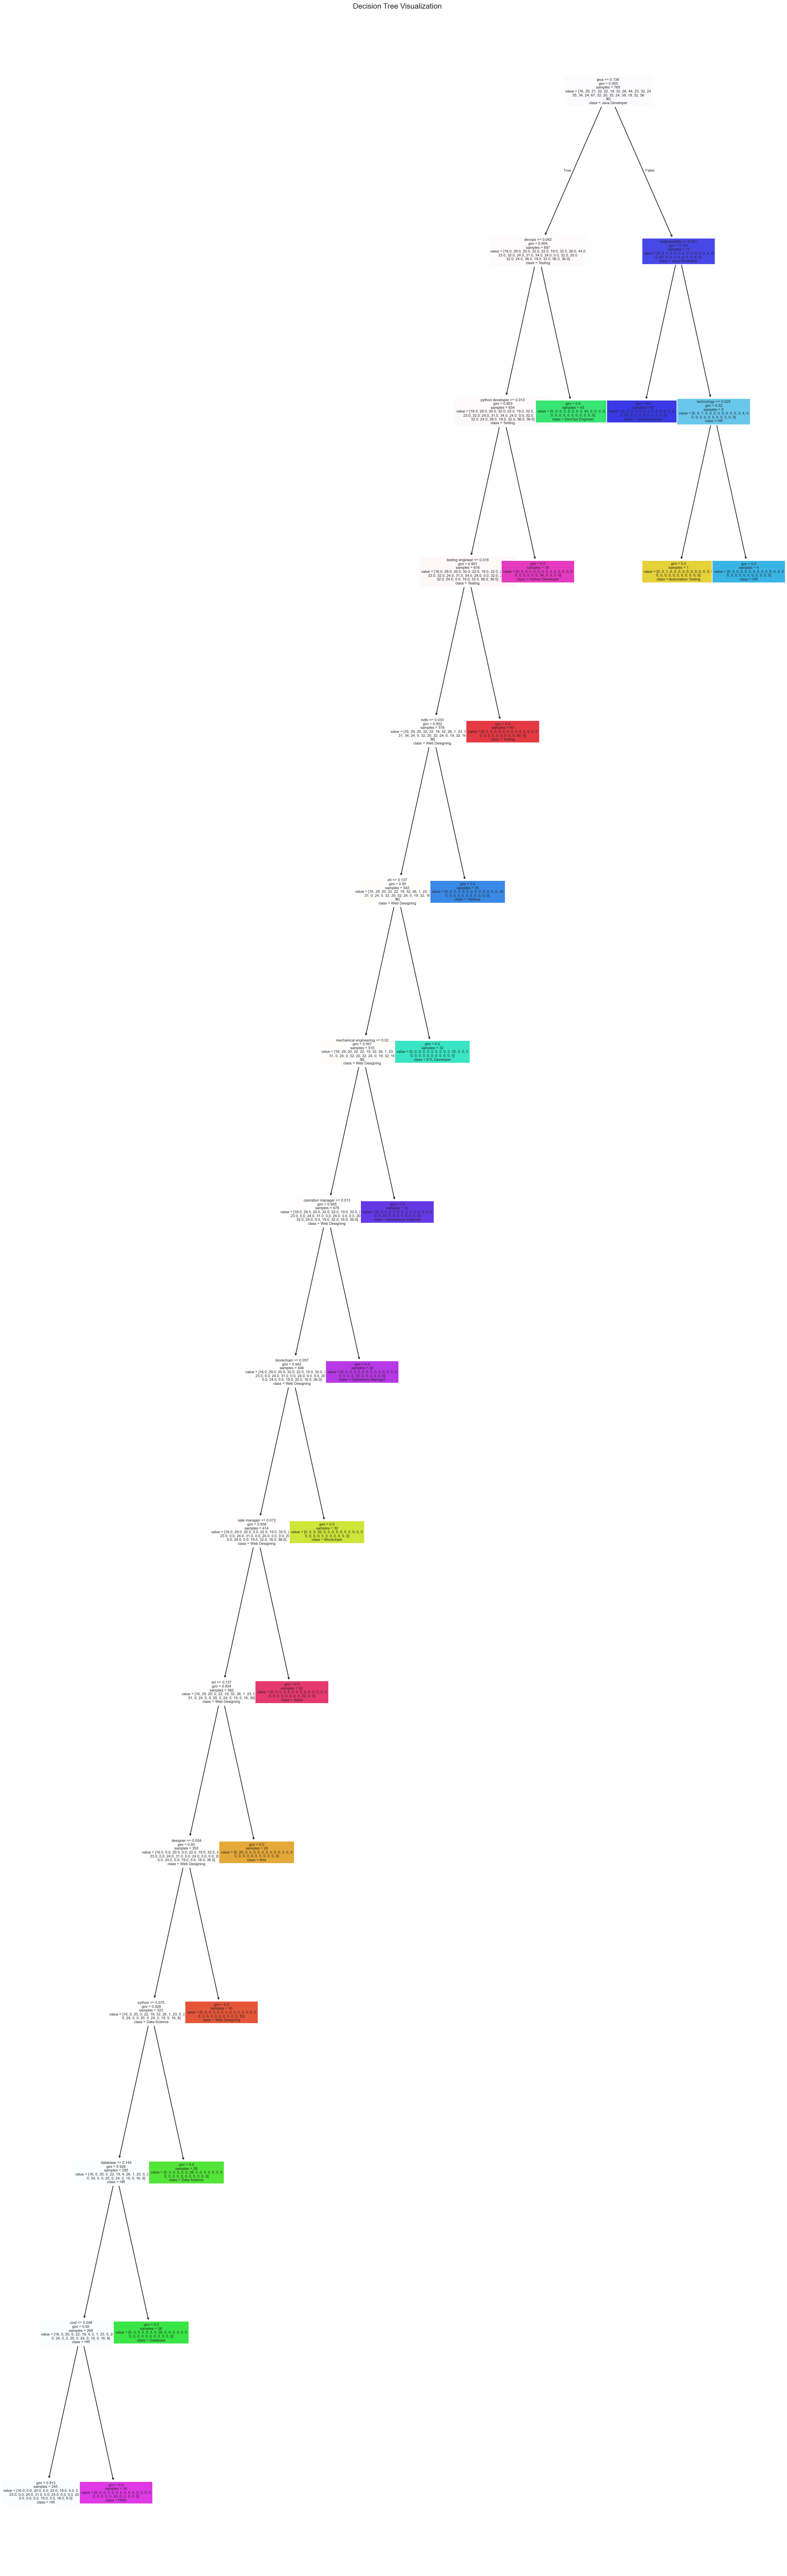

In [204]:
from sklearn import tree
import matplotlib.pyplot as plt
dt_model = results['Decision Tree']['model']

plt.figure(figsize=(30, 100))
tree.plot_tree(
    dt_model,
    filled=True,
    fontsize=8,
    class_names=le.classes_,
    feature_names=vectorizer.get_feature_names_out()
)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()


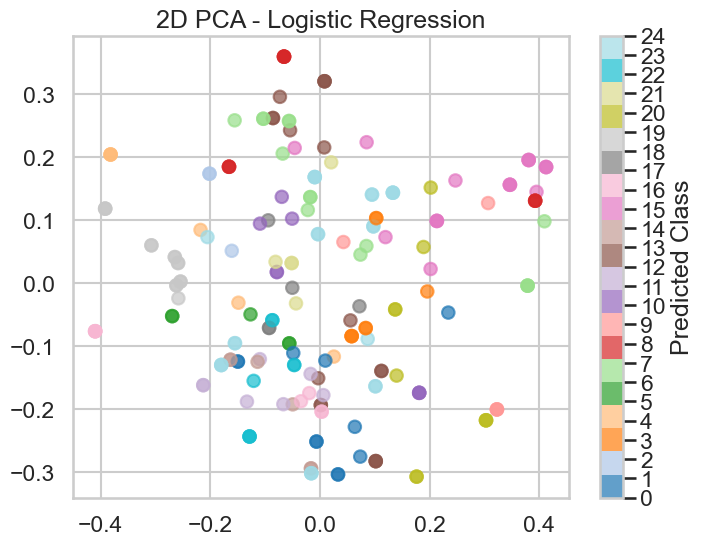

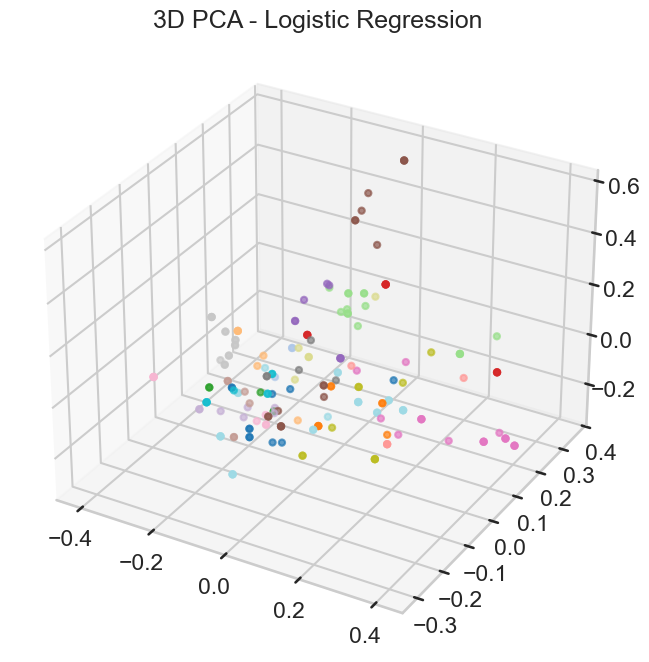

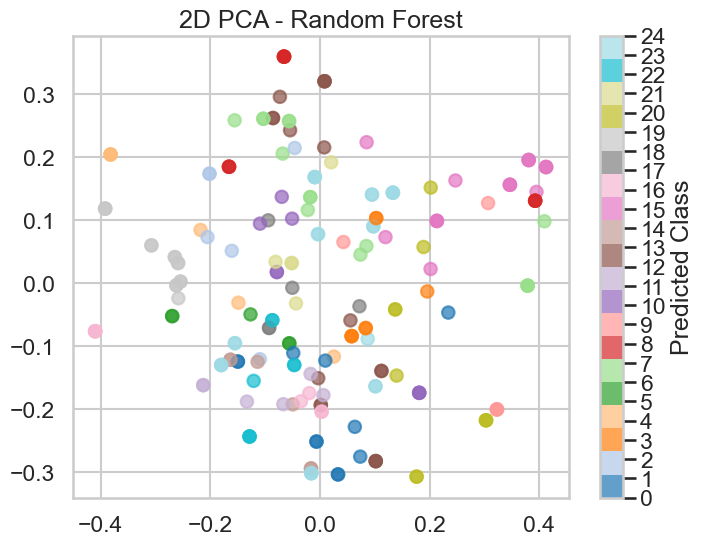

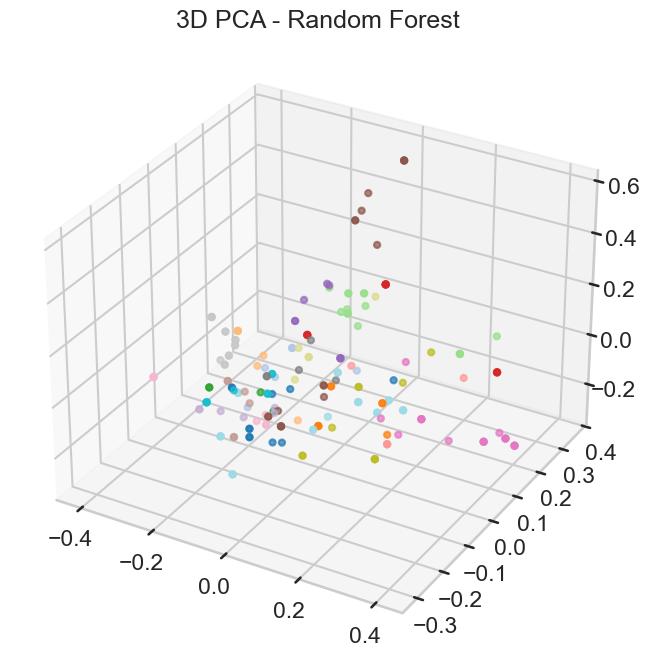

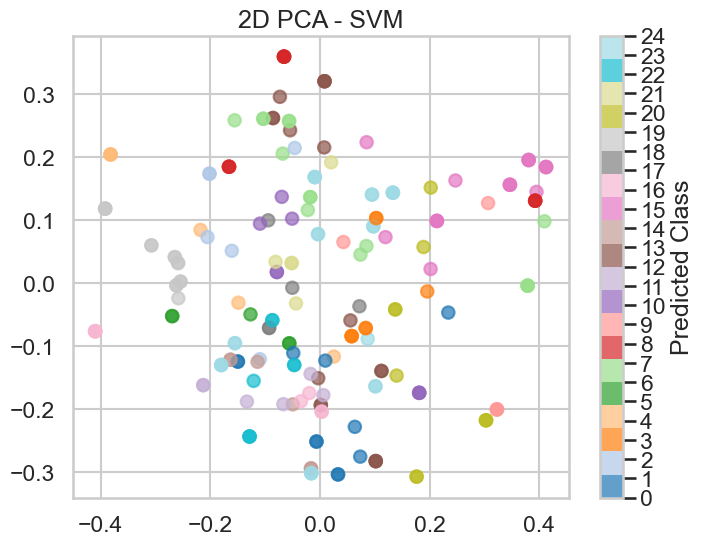

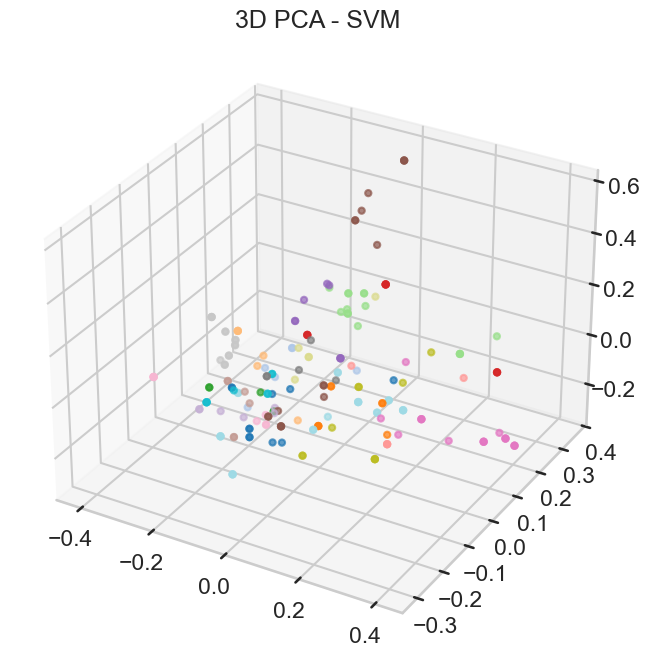

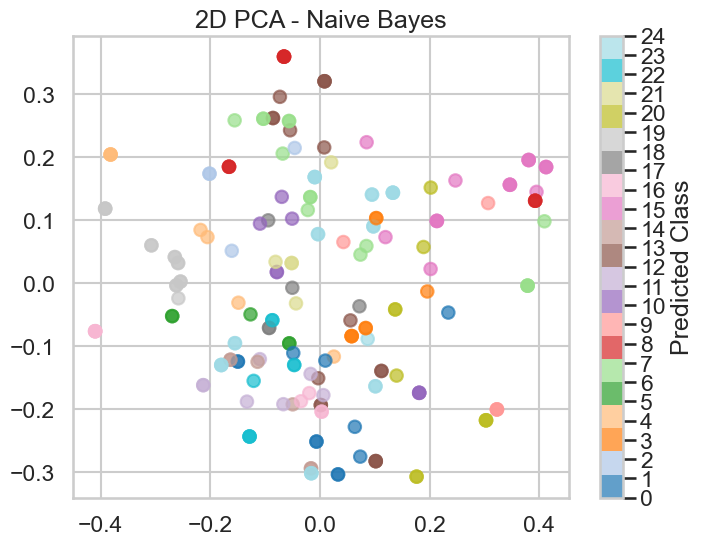

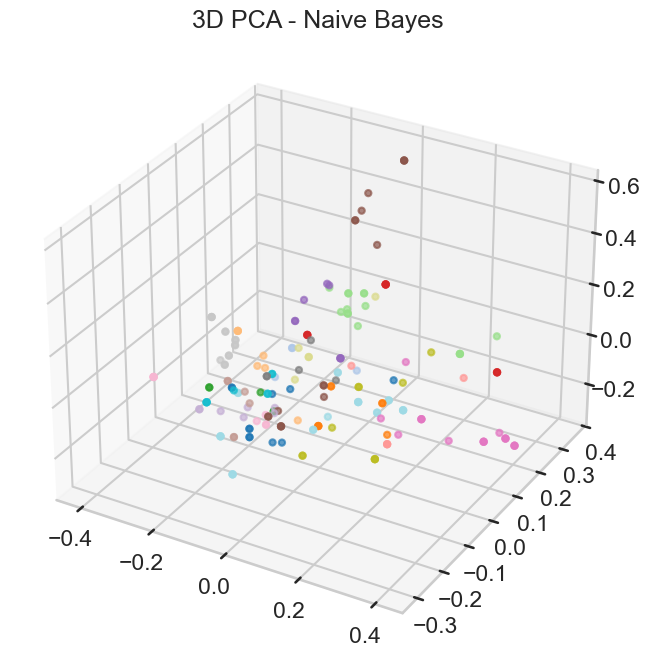

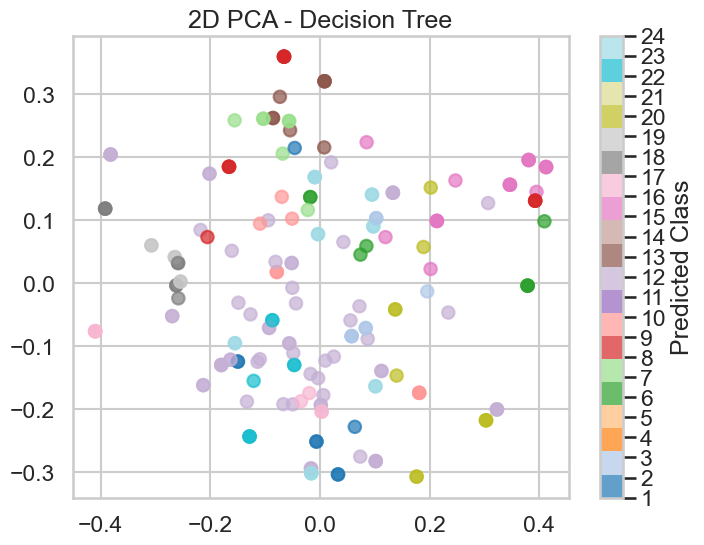

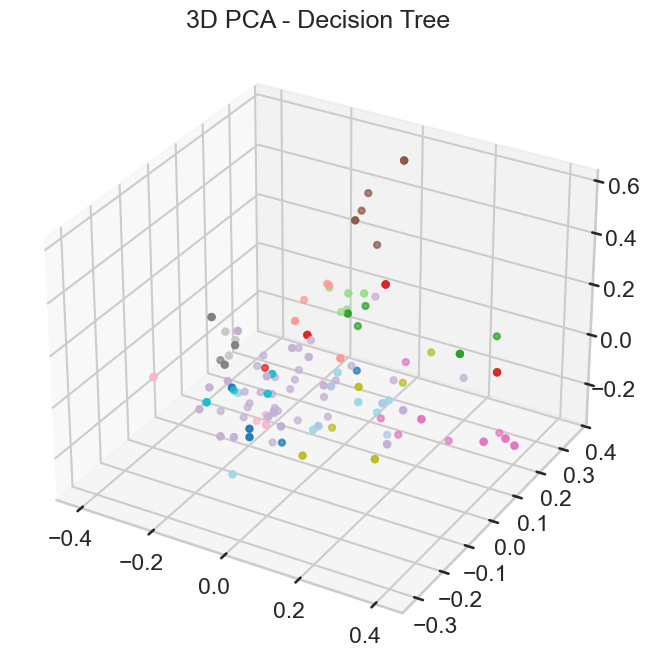

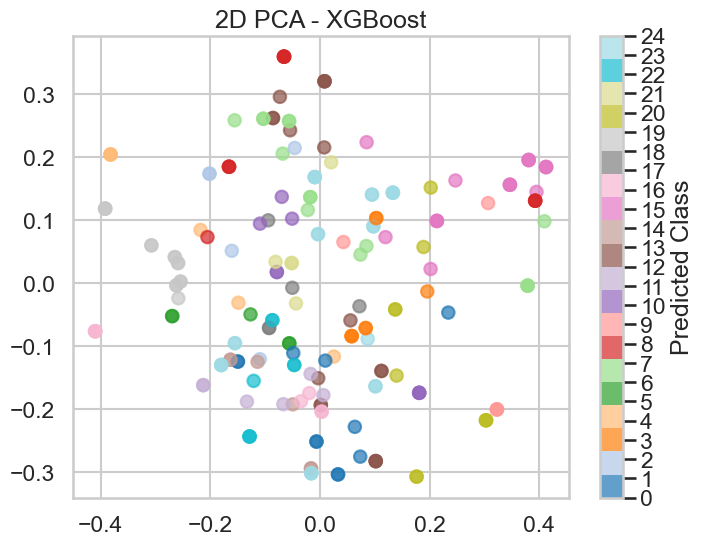

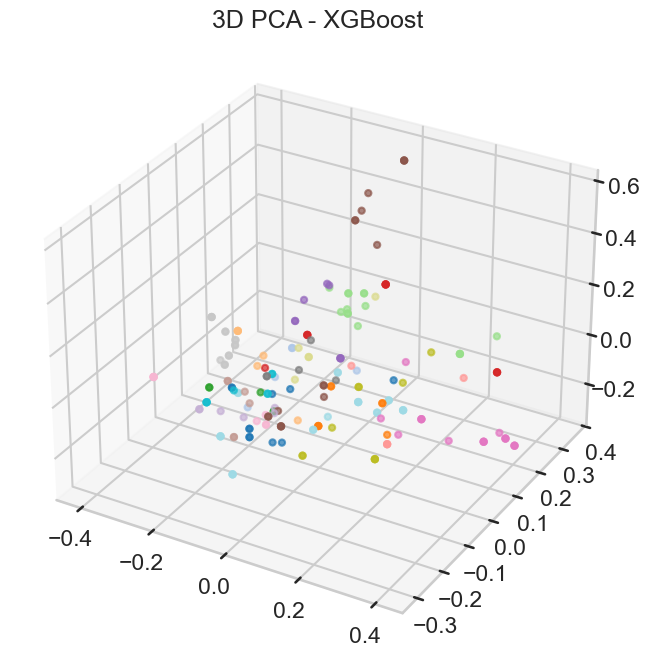

In [173]:
# Step 11: 2D & 3D PCA visualization
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_2d_3d(models_dict, X_test, y_test, le):
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(X_test.toarray())
    
    for model_name, model_data in models_dict.items():
        y_pred = model_data['model'].predict(X_test)
        y_pred_labels = le.inverse_transform(y_pred)
        
        # 2D
        plt.figure(figsize=(8,6))
        plt.scatter(X_reduced[:,0], X_reduced[:,1], c=[le.transform([l])[0] for l in y_pred_labels],
                    cmap='tab20', alpha=0.7)
        plt.colorbar(ticks=range(len(le.classes_)), label='Predicted Class')
        plt.title(f'2D PCA - {model_name}')
        plt.show()
        
        # 3D
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2],
                   c=[le.transform([l])[0] for l in y_pred_labels],
                   cmap='tab20', alpha=0.7)
        ax.set_title(f'3D PCA - {model_name}')
        plt.show()

plot_2d_3d(results, X_test, y_test, le)


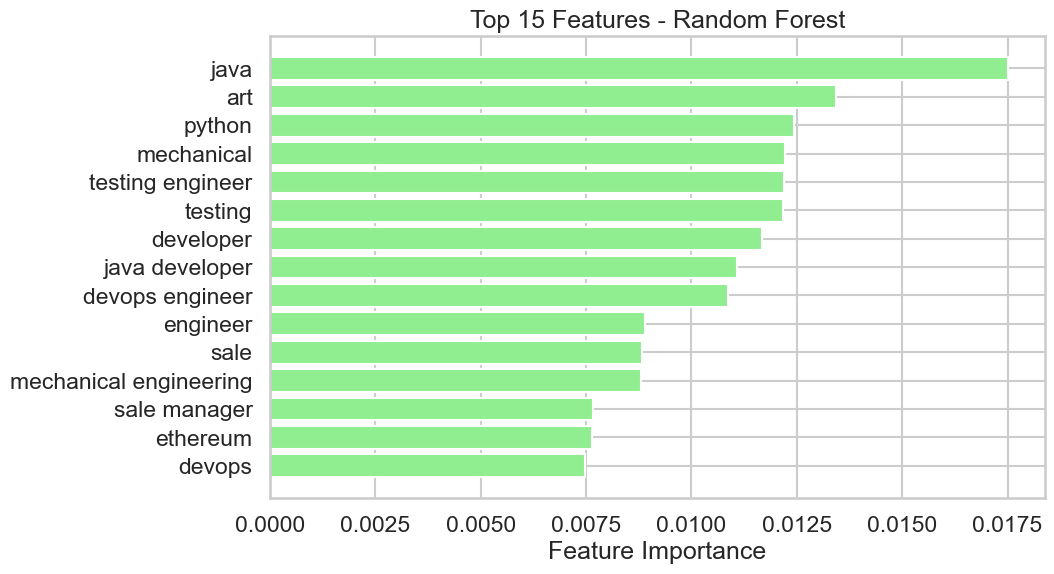

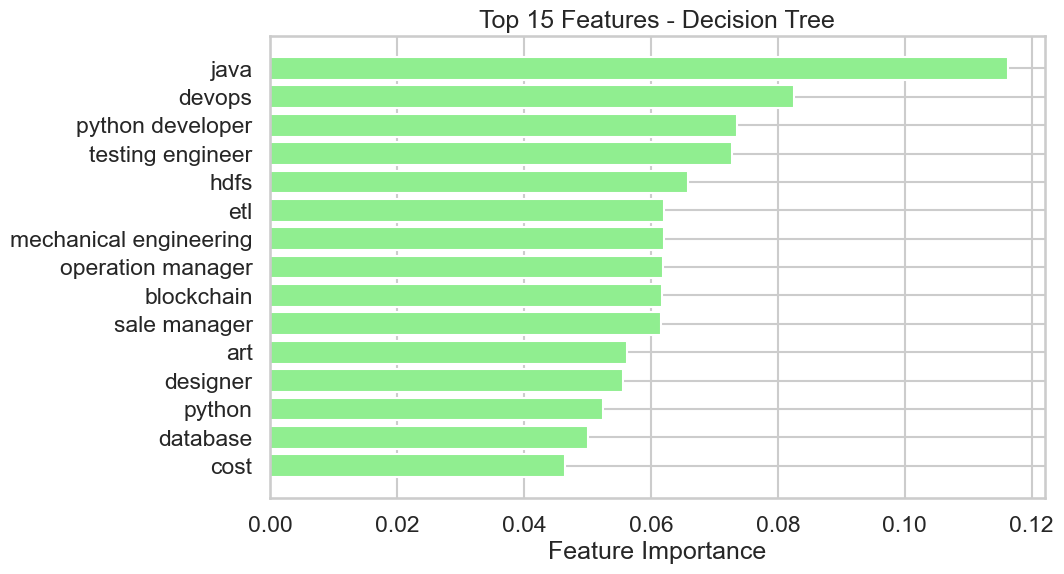

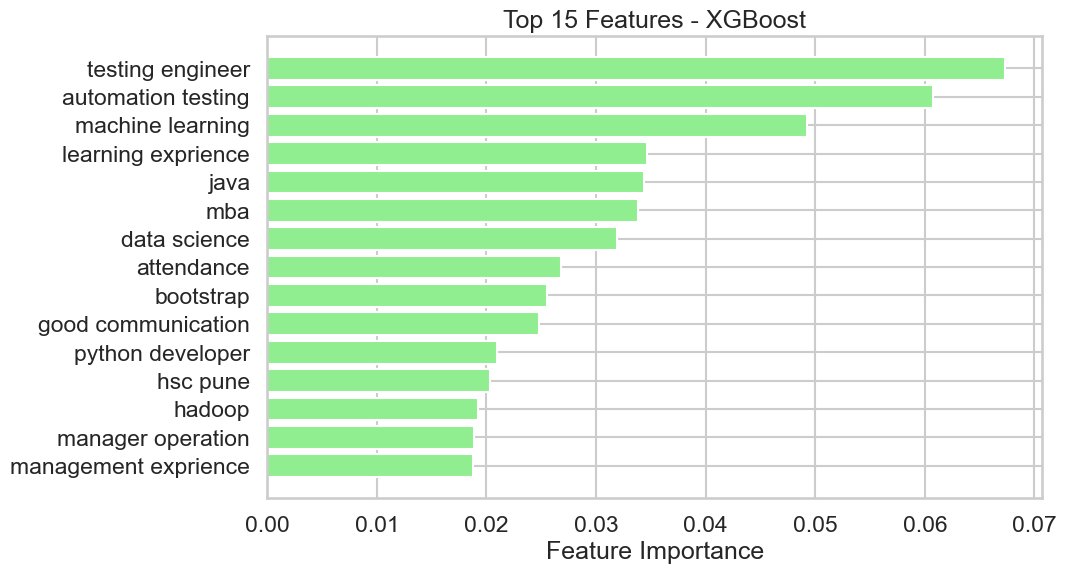

In [174]:
# Step 12: Feature importance
def plot_feature_importance(model, vectorizer, model_name, top_n=15):
    if hasattr(model, 'feature_importances_'):
        feature_names = vectorizer.get_feature_names_out()
        importances = model.feature_importances_
        indices = np.argsort(importances)[-top_n:]
        
        plt.figure(figsize=(10,6))
        plt.barh(range(top_n), importances[indices], color='lightgreen')
        plt.yticks(range(top_n), [feature_names[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_n} Features - {model_name}')
        plt.show()

for model_name in ['Random Forest', 'Decision Tree', 'XGBoost']:
    if model_name in results:
        plot_feature_importance(results[model_name]['model'], vectorizer, model_name)


In [175]:
import docx
import PyPDF2
import os

def extract_text_from_file(file_path):
    """Extract text from PDF, DOCX, or TXT"""
    ext = os.path.splitext(file_path)[1].lower()
    
    if ext == ".pdf":
        text = ""
        with open(file_path, 'rb') as f:
            reader = PyPDF2.PdfReader(f)
            for page in reader.pages:
                text += page.extract_text() + " "
        return text.strip()
    
    elif ext == ".docx":
        doc = docx.Document(file_path)
        text = " ".join([para.text for para in doc.paragraphs])
        return text.strip()
    
    elif ext == ".txt":
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        return text.strip()
    
    else:
        raise ValueError("Unsupported file type! Please use PDF, DOCX, or TXT.")

def test_resume_file(file_path, models_dict, vectorizer, le):
    """Test a resume file on all trained models"""
    try:
        resume_text = extract_text_from_file(file_path)
    except Exception as e:
        print(f"Error reading file: {e}")
        return
    
    cleaned_text = clean_text(resume_text)
    text_vec = vectorizer.transform([cleaned_text])
    
    print(f"\nTesting resume from file: {file_path}\n")
    for model_name, model_data in models_dict.items():
        model = model_data['model']
        pred_enc = model.predict(text_vec)[0]
        pred_label = le.inverse_transform([pred_enc])[0]
        prob = np.max(model.predict_proba(text_vec)) if hasattr(model, "predict_proba") else None
        prob_str = f"{prob:.2%}" if prob else "N/A"
        print(f"{model_name}: {pred_label} | Confidence: {prob_str}")


In [176]:
resume_file_path = "resume/resume.txt"
test_resume_file(resume_file_path, results, vectorizer, le)


Testing resume from file: resume/resume.txt

Logistic Regression: Data Science | Confidence: 31.48%
Random Forest: Data Science | Confidence: 61.38%
SVM: Data Science | Confidence: 51.12%
Naive Bayes: Data Science | Confidence: 99.84%
Decision Tree: Data Science | Confidence: 100.00%
XGBoost: Data Science | Confidence: 98.16%
